Completed model

In [1]:
(1)
# Data Processing and Visualization
import os
import random
import glob
import re

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import math

# Image Processing and Visualization
import matplotlib.pyplot as plt
import cv2
from skimage import io
from PIL import Image

# Deep Learning Framework (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
)
from tensorflow.keras.models import Model

# Specific TensorFlow/Keras Components
from tensorflow.keras import layers, optimizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, 
    EarlyStopping, 
    ModelCheckpoint, 
    LearningRateScheduler
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow.keras.backend as K

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from IPython.display import display
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import binary_crossentropy


Datamap imports the path of images and store them to a variable

In [2]:
(2)
datamap = []

# Specify the path to your dataset on your Windows machine
dataset_path = "Dataset_MRI"

# Iterate over subdirectories in the specified path
for sub_dir_path in glob.glob(dataset_path + "/*"):
    # Check if the current path is a directory
    if os.path.isdir(sub_dir_path):
        # Extract the tumor type from the directory name
        dir_name = os.path.basename(sub_dir_path)

        # Iterate over files in the directory
        for filename in os.listdir(sub_dir_path):
            # Construct the full path to the image file
            image_path = os.path.join(sub_dir_path, filename)
            
            # Load the image as an array
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            
            # Check if the image is successfully loaded
            if image is not None:
                # Append a dictionary to the datamap
                datamap.append({
                    'tumor_type': dir_name,
                    'file_name': filename,
                    'file_path': image_path,  # Include the full file path
                    'image': image
                })

# Display the datamap
for entry in datamap[:10]:  # Display only the first 10 entries
    print(f"Tumor Type: {entry['tumor_type']}, File Name: {entry['file_name']}, File Path: {entry['file_path']}, Image Shape: {entry['image'].shape}")


Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_11.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_11.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_12.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_12.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_13.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_13.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_14.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_14.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_15.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_15.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_16.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_16.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4942_19970222_10.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS

Coverting the datamap to dataframe

In [3]:
(3)
# Convert the data_map to a pandas DataFrame
datamap_df = pd.DataFrame(datamap)

# Display the first few rows of the DataFrame to verify its structure
print(datamap_df.head())
# print(df)

  tumor_type                     file_name  \
0    Gliomas  TCGA_CS_4941_19960909_11.tif   
1    Gliomas  TCGA_CS_4941_19960909_12.tif   
2    Gliomas  TCGA_CS_4941_19960909_13.tif   
3    Gliomas  TCGA_CS_4941_19960909_14.tif   
4    Gliomas  TCGA_CS_4941_19960909_15.tif   

                                          file_path  \
0  Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_11.tif   
1  Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_12.tif   
2  Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_13.tif   
3  Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_14.tif   
4  Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_15.tif   

                                               image  
0  [[[1, 1, 0], [1, 1, 0], [2, 2, 0], [2, 2, 0], ...  
1  [[[1, 4, 0], [2, 2, 0], [3, 2, 0], [2, 4, 0], ...  
2  [[[2, 3, 0], [3, 1, 0], [2, 2, 0], [1, 3, 0], ...  
3  [[[1, 2, 0], [1, 2, 0], [1, 4, 0], [1, 4, 0], ...  
4  [[[1, 5, 0], [2, 5, 0], [2, 4, 0], [2, 6, 0], ...  


Displaying the images before pre-processing

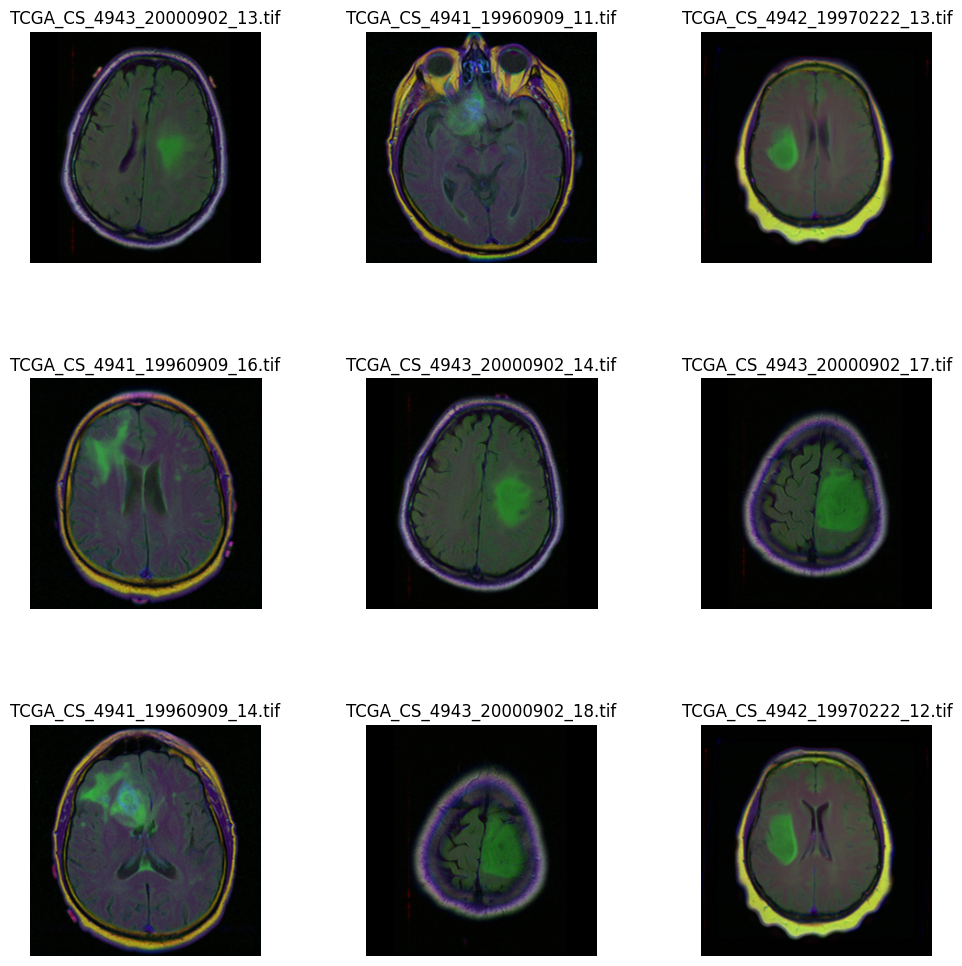

In [4]:
(4)
# Fixed number of images to display and columns
num_images_to_display = 9
num_cols = 3
num_rows = 3  # Since num_images_to_display is 9 and num_cols is 3

# Create a new figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Select random rows from the DataFrame
random_rows = datamap_df.sample(n=num_images_to_display)

# Iterate through the randomly selected rows to display images
for idx, (index, row) in enumerate(random_rows.iterrows()):
    # Determine the current row and column for the subplot
    current_row, current_col = divmod(idx, num_cols)

    # Load and display the image
    img = Image.open(row['file_path'])
    axes[current_row, current_col].imshow(img)
    axes[current_row, current_col].set_title(row['file_name'])
    axes[current_row, current_col].axis('off')

# Hide any empty subplots if necessary
for i in range(idx + 1, num_rows * num_cols):
    axes[i // num_cols, i % num_cols].axis('off')

# Adjust subplot spacing and display the figure
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()


Split data into training, testing, validation

In [5]:
(5)
# Import necessary libraries for splitting data
from sklearn.model_selection import train_test_split
import pandas as pd

# Split your data into training and validation sets
train_df, val_df = train_test_split(datamap_df, test_size=0.2, random_state=42)

# Ensure file paths are strings
train_df['file_path'] = train_df['file_path'].astype(str)
val_df['file_path'] = val_df['file_path'].astype(str)

# train_df and val_df are now ready for use
print("Size of train_df:", len(train_df))
print("Size of val_df:", len(val_df))

# Tumor type labels mapping
tumor_labels = {
    'no_tumor': 0,
    'Gliomas': 1,
    'Meningiomas': 2,
    'Pituitary_Tumor': 3,
    'Astrocytoma': 4,
    'Glioblastoma': 5,
    'Tumor_Type_6': 6
}

# Apply tumor type labels to the DataFrame
train_df['encoded_labels'] = train_df['tumor_type'].map(tumor_labels)
val_df['encoded_labels'] = val_df['tumor_type'].map(tumor_labels)

Size of train_df: 14
Size of val_df: 4


In [6]:
(6)
# Instantiate a LabelEncoder
label_encoder = LabelEncoder()

#Apply tumor type labels to the DataFrame
train_df['encoded_labels'] = train_df['tumor_type'].map(tumor_labels)
val_df['encoded_labels'] = val_df['tumor_type'].map(tumor_labels)

# Fit and transform the labels in the training set
train_df['encoded_labels'] = label_encoder.fit_transform(train_df['tumor_type'])

# Transform the labels in the validation set
val_df['encoded_labels'] = label_encoder.transform(val_df['tumor_type'])


In [7]:
train_image_paths = train_df['file_path'].tolist()
train_labels = train_df['encoded_labels'].tolist()

val_image_paths = val_df['file_path'].tolist()
val_labels = val_df['encoded_labels'].tolist()

Data Generator

In [8]:
(7)
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, image_size, num_classes, augmenter=None, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.augmenter = augmenter  # For image augmentation
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[k] for k in batch_indices]
        batch_labels = [self.labels[k] for k in batch_indices]
        X, y = self.__generate_Xy(batch_image_paths, batch_labels)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __generate_Xy(self, batch_image_paths, batch_labels):
        X = np.empty((self.batch_size, *self.image_size, 3))
        y = np.empty((self.batch_size, *self.image_size, self.num_classes))

        for i, (path, label) in enumerate(zip(batch_image_paths, batch_labels)):
            image = cv2.imread(path)

            # Ensure the image has 3 channels (convert grayscale to RGB if needed)
            if len(image.shape) == 2 or image.shape[2] == 1:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

            # Resize the image to the specified size
            image = cv2.resize(image, self.image_size)
            X[i,] = image / 255.0

            label_matrix = np.zeros((*self.image_size, self.num_classes))
            label_matrix[:, :, int(label)] = 1  # Convert label to categorical
            y[i,] = label_matrix

        return X, y

    def preprocess_image(self, image):
        # Check if the image is grayscale (single channel)
        if len(image.shape) == 2 or image.shape[2] == 1:
            # Convert grayscale to RGB by duplicating the channel
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        else:
            # Assuming the image is already in RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply OTSU's thresholding
        thresholded = apply_otsus_thresholding(image)

        # Resizing
        resized = resize_image(thresholded, self.image_size)

        # Image Augmentation (if augmenter is provided)
        if self.augmenter:
            resized = self.augmenter(resized)

        # Image Normalization
        normalized = resized / 255.0

        return normalized

# Helper preprocessing functions (add or modify as needed)
def apply_otsus_thresholding(image):
    # Convert to grayscale for thresholding
    grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresholded = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded

def resize_image(image, size=(256, 256)):
    return cv2.resize(image, size)

# Parameters for the data generator
batch_size = 32  # Example batch size, adjust as needed
image_size = (256, 256)  # Target image size as per the model input
num_classes = 7  # Adjust based on the number of tumor types or categories

# Instantiate the custom data generators
# Instantiate the custom data generators with encoded labels
train_generator = CustomDataGenerator(
    image_paths=train_df['file_path'].tolist(),
    labels=train_df['encoded_labels'].tolist(),  # Use encoded labels
    batch_size=batch_size,
    image_size=image_size,
    num_classes=num_classes,
    shuffle=True
)

val_generator = CustomDataGenerator(
    image_paths=val_df['file_path'].tolist(),
    labels=val_df['encoded_labels'].tolist(),  # Use encoded labels
    batch_size=batch_size,
    image_size=image_size,
    num_classes=num_classes,
    shuffle=False
)

Train-Data & Validation-Data

In [9]:
(9)
# Custom VGG16 Encoder
def custom_vgg16_encoder(input_tensor):
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    s1 = x  # Save the feature map for decoder
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    s2 = x  # Save the feature map for decoder
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    s3 = x  # Save the feature map for decoder

    return s3, s2, s1

# Custom U-Net Decoder
def custom_unet_decoder(conv4, conv3, conv2, conv1):
    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv4)
    u6 = layers.concatenate([u6, conv3], axis=-1)
    u6 = layers.BatchNormalization()(u6)
    u6 = layers.Activation('relu')(u6)
    u6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    u6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    u6 = layers.Dropout(0.5)(u6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = layers.concatenate([u7, conv2], axis=-1)
    u7 = layers.BatchNormalization()(u7)
    u7 = layers.Activation('relu')(u7)
    u7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    u7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    u7 = layers.Dropout(0.5)(u7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(u7)

    # Adjust the shape of conv1 to match the shape of u8
    conv1_adjusted = layers.Conv2D(128, (1, 1), activation='relu')(conv1)
    conv1_adjusted = layers.UpSampling2D(size=(2, 2))(conv1_adjusted)

    u8 = layers.concatenate([u8, conv1_adjusted], axis=-1)
    u8 = layers.BatchNormalization()(u8)
    u8 = layers.Activation('relu')(u8)
    u8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    u8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    u8 = layers.Dropout(0.5)(u8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = layers.BatchNormalization()(u9)
    u9 = layers.Activation('relu')(u9)
    u9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    u9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    u9 = layers.Dropout(0.5)(u9)
    return u9

# Build Custom UNet-VGG16 Model
def build_custom_unet_vgg16_for_rgb(input_shape, num_classes=7):
    inputs = tf.keras.layers.Input(input_shape)

    """ Encoder """
    s3, s2, s1 = custom_vgg16_encoder(inputs)

    """ Decoder (U-Net) """
    u_net_decoder_output = custom_unet_decoder(s3, s2, s1, s1)

    """ Output """
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(u_net_decoder_output)

    model = tf.keras.models.Model(inputs, outputs, name="Custom_RGB_Brain_Tumor_Segmentation_Model")
    return model

# Create the model instance for RGB input
custom_rgb_model = build_custom_unet_vgg16_for_rgb((256, 256, 3), num_classes=7)

# Compile the model
custom_rgb_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
custom_rgb_model.summary()





Model: "Custom_RGB_Brain_Tumor_Segmentation_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                    

Custom Loss Function

In [10]:
(10)
epsilon = 1e-5
smooth = 1

def categorical_tversky_index(y_true, y_pred, alpha=0.7):
    # Get the dynamic shape
    shape = tf.shape(y_true)
    y_true = K.reshape(y_true, [-1, shape[-3], shape[-2], shape[-1]])
    y_pred = K.reshape(y_pred, [-1, shape[-3], shape[-2], shape[-1]])

    # Calculate Tversky index for each pixel and then average over all pixels
    true_positives = K.sum(y_true * y_pred, axis=[1, 2])
    false_negatives = K.sum(y_true * (1 - y_pred), axis=[1, 2])
    false_positives = K.sum((1 - y_true) * y_pred, axis=[1, 2])

    tversky_index = (true_positives + smooth) / (true_positives + alpha * false_negatives + (1 - alpha) * false_positives + smooth)
    return K.mean(tversky_index)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tversky_index = categorical_tversky_index(y_true, y_pred)
    return K.pow((1 - tversky_index), gamma)

# Custom loss function
def modified_categorical_crossentropy(y_true, y_pred):
    # Ensure y_true and y_pred are 4D
    y_true = K.reshape(y_true, (-1, y_true.shape[-3], y_true.shape[-2], y_true.shape[-1]))
    y_pred = K.reshape(y_pred, (-1, y_pred.shape[-3], y_pred.shape[-2], y_pred.shape[-1]))

    # Calculate categorical crossentropy for each pixel and then average
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return K.mean(cce) + (1 - categorical_tversky_index(y_true, y_pred))


Custom Scores

Checkpoints

In [11]:
(11)
# Custom loss function
def modified_categorical_crossentropy(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + (1 - categorical_tversky_index(y_true, y_pred))

# Optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.1, epsilon=0.1)

# Compile the model
custom_rgb_model.compile(optimizer=adam, loss=modified_categorical_crossentropy, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Define a custom callback to save the entire training history
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, csv_filename="training_history.csv"):
        self.csv_filename = csv_filename
        # Read existing data if file exists
        if os.path.exists(self.csv_filename):
            self.epoch_history = pd.read_csv(self.csv_filename).to_dict('records')
        else:
            self.epoch_history = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # If resuming from previous training, adjust the epoch number
        if self.epoch_history:
            last_epoch = self.epoch_history[-1]['epoch']
            logs['epoch'] = last_epoch + 1
        else:
            logs['epoch'] = epoch + 1

        self.epoch_history.append(logs)
        # Save updated history to CSV
        pd.DataFrame(self.epoch_history).to_csv(self.csv_filename, index=False)

save_history_callback = SaveHistoryCallback(csv_filename="Model_Weights/training_history.csv")

checkpointer = ModelCheckpoint(filepath="Model_Weights/brain_tumor_model_weights.hdf5",
                               verbose=1,
                               save_best_only=True,
                               restore_best_weights=True)

# ReduceLROnPlateau: Reduce learning rate if no improvement in 'patience' epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0000001, verbose=1)

# EarlyStopping: Stop training if no improvement after 'patience' epochs even after learning rate reductions
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=4, verbose=1)


History

In [12]:
# Read existing CSV file for last epoch
last_epoch = 0
if os.path.exists("training_history.csv"):
    df = pd.read_csv("training_history.csv")
    if not df.empty:
        last_epoch = df['epoch'].max()

Epochs

In [13]:
(12)
# Total number of epochs to train
total_epochs = 200
# Train the model with the callbacks
history = custom_rgb_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    callbacks=[early_stopping, reduce_lr, checkpointer, save_history_callback],
    verbose=1
)

# Access the entire training history
entire_training_history = save_history_callback.epoch_history


Epoch 1/200


1/1 [==============================] - ETA: 0s - loss: 1.8427 - accuracy: 0.2178
Epoch 1: val_loss improved from inf to 1.23690, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 45s 45s/step - loss: 1.8427 - accuracy: 0.2178 - val_loss: 1.2369 - val_accuracy: 1.0000 - lr: 0.1000 - epoch: 37.0000
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 1.4441 - accuracy: 0.8001
Epoch 2: val_loss improved from 1.23690 to 1.23342, saving model to Model_Weights\brain_tumor_model_weights.hdf5
1/1 [==============================] - 38s 38s/step - loss: 1.4441 - accuracy: 0.8001 - val_loss: 1.2334 - val_accuracy: 1.0000 - lr: 0.1000 - epoch: 38.0000
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 1.1894 - accuracy: 0.9848
Epoch 3: val_loss improved from 1.23342 to 1.22993, saving model to Model_Weights\brain_tumor_model_weights.hdf5
1/1 [==============================] - 38s 38s/step - loss: 1.1894 - accuracy: 0.9848 - val_loss: 1.2299 - val_accuracy: 1.0000 - lr: 0.1000 - epoch: 39.0000
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 1.0971 - accuracy: 0.9980
Epoch 4: val_loss imp

PermissionError: [Errno 13] Permission denied: 'Model_Weights/training_history.csv'

Predictions